In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [58]:
# /kaggle/input/hackerearth-deep-learning-identify-the-snake-breed/
train_dir='dataset/train'
test_dir='dataset/test'

In [59]:
train=pd.read_csv('dataset/train.csv')
train.head(5)

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [60]:
test=pd.read_csv('dataset/test.csv')
test.head(5)

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [61]:
num=len(train['breed'].unique())
print("Total Labels : ",str(num))

Total Labels :  35


In [62]:
train['breed'].value_counts()

thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
thamnophis-radix               100
pantherophis-guttatus          100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
masticophis-flagellum           83
crotalus-viridis                83
thamnophis-marcianus            82
crotalus-ruber      

In [63]:
train['image_id']=train['image_id'].apply(lambda x:os.path.join(x+'.jpg'))
train.head(5)

,image_id,breed
0,a8b3ad1dde.jpg,nerodia-erythrogaster
1,8b492b973d.jpg,pantherophis-vulpinus
2,929b99ea92.jpg,thamnophis-sirtalis
3,bbac7385e2.jpg,pantherophis-obsoletus
4,ef776b1488.jpg,agkistrodon-contortrix


In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, Callback
from tensorflow.keras.layers import Dropout, Dense, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [65]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

In [66]:
train_it=datagen.flow_from_dataframe(
                                            train,
                                            directory=train_dir,
                                            x_col="image_id",
                                            y_col="breed",
                                            target_size=(150,150),
                                            class_mode='categorical',
                                            batch_size=32,
                                            subset="training",
                                            shuffle=True)
valid_it=datagen.flow_from_dataframe(
                                            train,
                                            directory=train_dir,
                                            x_col="image_id",
                                            y_col="breed",
                                            target_size=(150,150),
                                            class_mode='categorical',
                                            subset='validation',
                                            batch_size=32,
                                            shuffle=True)

Found 4407 validated image filenames belonging to 35 classes.
Found 1101 validated image filenames belonging to 35 classes.


In [67]:
model=Sequential()
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', input_shape = (150,150,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num, activation='softmax'))

In [68]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 146, 146, 16)      1216      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 69, 69, 32)        12832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        51264     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 64)      

In [69]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [70]:
class myCallback(Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('accuracy')>=0.98:
            print("\nReached More than 98% accuraccy")
            self.model.stop_training=True
callback=myCallback()

In [96]:
history=model.fit(train_it,validation_data=valid_it,epochs=1500,callbacks=[callback])

Epoch 1/1500


2023-05-20 21:16:01.136216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


136/138 [============================>.] - ETA: 0s - loss: 3.3633 - accuracy: 0.0916

2023-05-20 21:16:03.595358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


138/138 [==============================] - 3s 20ms/step - loss: 3.3632 - accuracy: 0.0919 - val_loss: 3.3741 - val_accuracy: 0.0945
Epoch 2/1500
138/138 [==============================] - 3s 19ms/step - loss: 3.3633 - accuracy: 0.0919 - val_loss: 3.3741 - val_accuracy: 0.0945
Epoch 3/1500
138/138 [==============================] - 3s 20ms/step - loss: 3.3641 - accuracy: 0.0919 - val_loss: 3.3738 - val_accuracy: 0.0945
Epoch 4/1500
138/138 [==============================] - 3s 20ms/step - loss: 3.3631 - accuracy: 0.0919 - val_loss: 3.3739 - val_accuracy: 0.0945
Epoch 5/1500
138/138 [==============================] - 3s 21ms/step - loss: 3.3633 - accuracy: 0.0919 - val_loss: 3.3748 - val_accuracy: 0.0945
Epoch 6/1500
138/138 [==============================] - 3s 21ms/step - loss: 3.3634 - accuracy: 0.0919 - val_loss: 3.3746 - val_accuracy: 0.0945
Epoch 7/1500
138/138 [==============================] - 3s 21ms/step - loss: 3.3633 - accuracy: 0.0919 - val_loss: 3.3747 - val_accuracy: 0.094

KeyboardInterrupt: 

In [92]:
import matplotlib.pyplot as plt

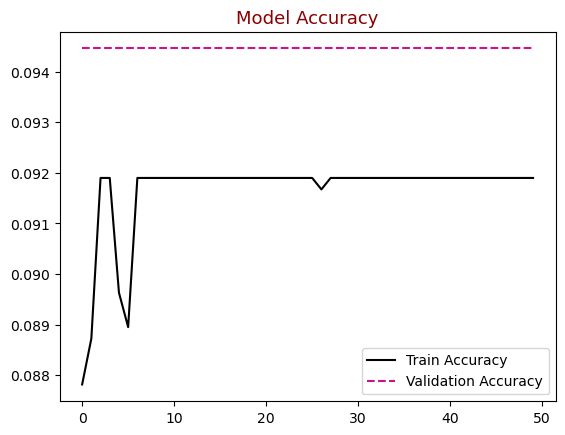

In [94]:
plt.figure()
plt.plot(history.history["accuracy"],label="Train Accuracy",color="black")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy",color="mediumvioletred",linestyle="dashed",markeredgecolor="purple",markeredgewidth=2)
plt.title("Model Accuracy",color="darkred",size=13)
plt.legend()
plt.show()

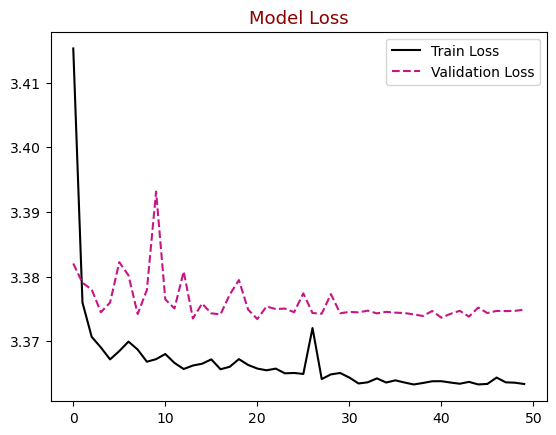

In [95]:
plt.figure()
plt.plot(history.history["loss"],label="Train Loss",color="black")
plt.plot(history.history["val_loss"],label="Validation Loss",color="mediumvioletred",linestyle="dashed",markeredgecolor="purple",markeredgewidth=2)
plt.title("Model Loss",color="darkred",size=13)
plt.legend()
plt.show()

In [72]:
preds_list=test['image_id']
preds_list

0       7ede553357
1       3500b219e4
2       d43a78d6d9
3       1f36f26994
4       8cb85fc58e
           ...    
2356    93e591cb23
2357    68a603b39d
2358    4f472510f3
2359    d6884444ae
2360    c0fa7df5de
Name: image_id, Length: 2361, dtype: object

In [76]:
test['image']=test['image_id'].apply(lambda x:os.path.join(x+'.jpg'))
test

,image_id,image
0,7ede553357,7ede553357.jpg
1,3500b219e4,3500b219e4.jpg
2,d43a78d6d9,d43a78d6d9.jpg
3,1f36f26994,1f36f26994.jpg
4,8cb85fc58e,8cb85fc58e.jpg
...,...,...
2356,93e591cb23,93e591cb23.jpg
2357,68a603b39d,68a603b39d.jpg
2358,4f472510f3,4f472510f3.jpg
2359,d6884444ae,d6884444ae.jpg


In [77]:
test_datagen=ImageDataGenerator(rescale=1./255.)
SIZE=(150,150,3)
test_generator=test_datagen.flow_from_dataframe(
    test,
    directory=test_dir,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=(150,150)
)

Found 2361 validated image filenames.


In [78]:
preds=model.predict(test_generator)
print(preds)

 1/74 [..............................] - ETA: 6s

2023-05-20 21:10:32.335334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 2s 21ms/step
[[0.03820892 0.02857067 0.02291412 ... 0.02149793 0.0195622  0.08646835]
 [0.03820892 0.02857067 0.02291412 ... 0.02149793 0.0195622  0.08646835]
 [0.03820892 0.02857067 0.02291412 ... 0.02149793 0.0195622  0.08646835]
 ...
 [0.03820886 0.02857069 0.02291414 ... 0.02149798 0.01956223 0.0864679 ]
 [0.03820886 0.02857069 0.02291414 ... 0.02149798 0.01956223 0.0864679 ]
 [0.03820886 0.02857069 0.02291414 ... 0.02149798 0.01956223 0.0864679 ]]


In [79]:
y_pred=[np.argmax(probas) for probas in preds]

In [80]:
len(y_pred)

2361

In [81]:
labels=train['breed'].unique()

In [82]:
y_p=set(y_pred)
y_p

{34}

In [83]:
prediction=[]
for i in y_pred:
#     if i==0:
#         prediction.append(labels[0])
#     elif i==1:
#         prediction.append(labels[1])
#     elif i==2:
#         prediction.append(labels[2])
#     elif i==3:
#         prediction.append(labels[3])
#     elif i==4:
#         prediction.append(labels[4])
#     elif i==5:
#         prediction.append(labels[5])
#     elif i==6:
#         prediction.append(labels[6])
#     elif i==7:
#         prediction.append(labels[7])
#     elif i==8:
#         prediction.append(labels[8])
    prediction.append(labels[i])

In [84]:
test

,image_id,image
0,7ede553357,7ede553357.jpg
1,3500b219e4,3500b219e4.jpg
2,d43a78d6d9,d43a78d6d9.jpg
3,1f36f26994,1f36f26994.jpg
4,8cb85fc58e,8cb85fc58e.jpg
...,...,...
2356,93e591cb23,93e591cb23.jpg
2357,68a603b39d,68a603b39d.jpg
2358,4f472510f3,4f472510f3.jpg
2359,d6884444ae,d6884444ae.jpg


In [85]:
preds_list

0       7ede553357
1       3500b219e4
2       d43a78d6d9
3       1f36f26994
4       8cb85fc58e
           ...    
2356    93e591cb23
2357    68a603b39d
2358    4f472510f3
2359    d6884444ae
2360    c0fa7df5de
Name: image_id, Length: 2361, dtype: object

In [86]:
results=pd.DataFrame({"image_id":preds_list,"breed":prediction})

In [87]:
results

,image_id,breed
0,7ede553357,crotalus-scutulatus
1,3500b219e4,crotalus-scutulatus
2,d43a78d6d9,crotalus-scutulatus
3,1f36f26994,crotalus-scutulatus
4,8cb85fc58e,crotalus-scutulatus
...,...,...
2356,93e591cb23,crotalus-scutulatus
2357,68a603b39d,crotalus-scutulatus
2358,4f472510f3,crotalus-scutulatus
2359,d6884444ae,crotalus-scutulatus


In [88]:
results['breed'].unique()

array(['crotalus-scutulatus'], dtype=object)

In [89]:
train['breed'].unique()

array(['nerodia-erythrogaster', 'pantherophis-vulpinus',
       'thamnophis-sirtalis', 'pantherophis-obsoletus',
       'agkistrodon-contortrix', 'crotalus-atrox',
       'lampropeltis-triangulum', 'crotalus-horridus', 'crotalus-ruber',
       'heterodon-platirhinos', 'nerodia-sipedon', 'thamnophis-elegans',
       'thamnophis-marcianus', 'crotalus-viridis', 'nerodia-fasciata',
       'haldea-striatula', 'storeria-dekayi', 'agkistrodon-piscivorus',
       'nerodia-rhombifer', 'storeria-occipitomaculata',
       'thamnophis-radix', 'coluber-constrictor', 'natrix-natrix',
       'diadophis-punctatus', 'masticophis-flagellum',
       'pantherophis-spiloides', 'rhinocheilus-lecontei',
       'lampropeltis-californiae', 'pituophis-catenifer',
       'opheodrys-aestivus', 'pantherophis-guttatus',
       'pantherophis-alleghaniensis', 'thamnophis-proximus',
       'pantherophis-emoryi', 'crotalus-scutulatus'], dtype=object)

In [90]:
results.to_csv('submission.csv',index=False)